In [1]:
# Set some environment variables
import os
gpu_num = 0 # GPU to be used. Use "" to use the CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress some TF warnings
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Fix the seed for reproducible results
tf.random.set_seed(42)

E0000 00:00:1750095944.586667   10332 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750095944.589728   10332 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750095944.597875   10332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750095944.597893   10332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750095944.597894   10332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750095944.597895   10332 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# Import Sionna RT components
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, PathSolver, RadioMapSolver, subcarrier_frequencies

# For link-level simulations
from sionna.phy import mapping,ofdm,utils
from sionna.phy.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset, AWGN
from sionna.phy.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.phy.utils import compute_ber, ebnodb2no, PlotBER
from sionna.phy.ofdm import KBestDetector, LinearDetector, ResourceGrid
from sionna.phy.mapping import Constellation, Mapper, Demapper
from sionna.phy.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.phy.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.phy.fec.turbo import TurboEncoder, TurboDecoder
from sionna.phy.fec.linear import OSDecoder
from sionna.phy.mapping import BinarySource
from sionna.phy.utils.metrics import  count_block_errors
from sionna.phy.mimo import StreamManagement

import scipy.special as sp
import scipy.stats as stats

# For the implementation of the Keras models
from tensorflow.keras import Model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

6.5
Position: 6.5m | Distance: 1.02m | Path Loss: 41.87 dB
6.0
Position: 6.0m | Distance: 1.51m | Path Loss: 45.02 dB
5.5
Position: 5.5m | Distance: 2.01m | Path Loss: 47.22 dB
5.0
Position: 5.0m | Distance: 2.51m | Path Loss: 48.82 dB
4.5
Position: 4.5m | Distance: 3.01m | Path Loss: 50.12 dB
4.0
Position: 4.0m | Distance: 3.51m | Path Loss: 51.17 dB
3.5
Position: 3.5m | Distance: 4.00m | Path Loss: 52.04 dB
3.0
Position: 3.0m | Distance: 4.50m | Path Loss: 52.24 dB
2.5
Position: 2.5m | Distance: 5.00m | Path Loss: 53.99 dB
2.0
Position: 2.0m | Distance: 5.50m | Path Loss: 54.41 dB
1.5
Position: 1.5m | Distance: 6.00m | Path Loss: 54.62 dB
1.0
Position: 1.0m | Distance: 6.50m | Path Loss: 55.70 dB
0.5
Position: 0.5m | Distance: 7.00m | Path Loss: 55.94 dB
0.0
Position: 0.0m | Distance: 7.50m | Path Loss: 56.28 dB
-0.5
Position: -0.5m | Distance: 8.00m | Path Loss: 57.46 dB
-1.0
Position: -1.0m | Distance: 8.50m | Path Loss: 57.72 dB
-1.5
Position: -1.5m | Distance: 9.00m | Path Loss: 

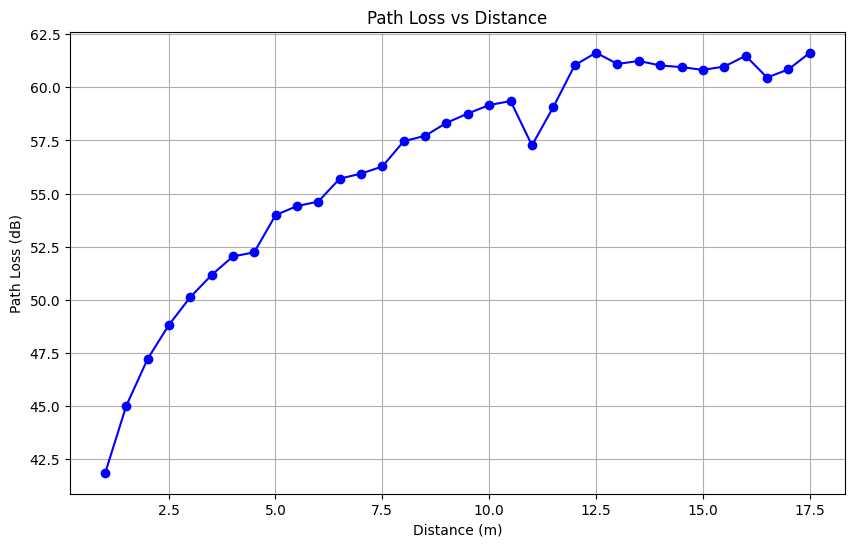


Summary:
Distance: 1.02m | Path Loss: 41.87 dB
Distance: 1.51m | Path Loss: 45.02 dB
Distance: 2.01m | Path Loss: 47.22 dB
Distance: 2.51m | Path Loss: 48.82 dB
Distance: 3.01m | Path Loss: 50.12 dB
Distance: 3.51m | Path Loss: 51.17 dB
Distance: 4.00m | Path Loss: 52.04 dB
Distance: 4.50m | Path Loss: 52.24 dB
Distance: 5.00m | Path Loss: 53.99 dB
Distance: 5.50m | Path Loss: 54.41 dB
Distance: 6.00m | Path Loss: 54.62 dB
Distance: 6.50m | Path Loss: 55.70 dB
Distance: 7.00m | Path Loss: 55.94 dB
Distance: 7.50m | Path Loss: 56.28 dB
Distance: 8.00m | Path Loss: 57.46 dB
Distance: 8.50m | Path Loss: 57.72 dB
Distance: 9.00m | Path Loss: 58.33 dB
Distance: 9.50m | Path Loss: 58.77 dB
Distance: 10.00m | Path Loss: 59.16 dB
Distance: 10.50m | Path Loss: 59.36 dB
Distance: 11.00m | Path Loss: 57.27 dB
Distance: 11.50m | Path Loss: 59.07 dB
Distance: 12.00m | Path Loss: 61.04 dB
Distance: 12.50m | Path Loss: 61.63 dB
Distance: 13.00m | Path Loss: 61.10 dB
Distance: 13.50m | Path Loss: 61.

In [15]:
# Load scene and configure arrays
scene = load_scene('/home/minhaj/weeks_hall_final/weeks_hall_final.xml', merge_shapes=False)
scene.tx_array = PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
scene.frequency = 3.5e9
scene.synthetic_array = True

# Create fixed transmitter
tx = Transmitter(name="tx", position=[7.5, 0, 1], display_radius=0.5)
scene.add(tx)

# Instantiate path solver
p_solver = PathSolver()

# Prepare positions and storage
x_positions = np.arange(6.5, -10.5, -0.5)  # From 6.5 to 10.5 inclusive, step 0.5
distances = []
path_losses = []

for x_pos in x_positions:
    # Convert numpy float64 to native Python float
    x_native = float(x_pos)
    print(x_native)
    
    # Create new receiver with native float position
    rx = Receiver(name=f"rx_{x_native:.1f}", 
                  position=[x_native, 0.0, 1.2],  # All values as native floats
                  display_radius=0.5)
    scene.add(rx)
    
    # Calculate Euclidean distance
    distance = np.linalg.norm(np.array(tx.position) - np.array(rx.position))
    distances.append(distance)
    
    # Compute paths
    paths = p_solver(
        scene=scene,
        max_depth=10,
        los=True,
        specular_reflection=True,
        diffuse_reflection=True,
        refraction=True,
        synthetic_array=False,
        seed=41
    )
    
    # Extract and process channel coefficients
    arr = np.array(paths.a[0])  # Get coefficients for this RX
    arr_squeezed = np.squeeze(arr)
    
    # Calculate total path loss
    power_gain_lin = np.sum(np.abs(arr_squeezed)**2)
    path_loss_dB = -10 * np.log10(power_gain_lin) if power_gain_lin > 0 else 200
    path_losses.append(path_loss_dB)
    
    # Clean up for next iteration
    scene.remove(rx.name)
    print(f"Position: {x_pos:.1f}m | Distance: {distance:.2f}m | Path Loss: {path_loss_dB:.2f} dB")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(distances, path_losses, 'bo-', markersize=6)
plt.title("Path Loss vs Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Path Loss (dB)")
plt.grid(True)
plt.show()

# Print summary
print("\nSummary:")
for dist, pl in zip(distances, path_losses):
    print(f"Distance: {dist:.2f}m | Path Loss: {pl:.2f} dB")

In [4]:
scene = load_scene('/home/minhaj/weeks_hall_final/weeks_hall_final.xml', merge_shapes=False)

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0,
                             horizontal_spacing=0,
                             pattern="iso",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1, 
                             vertical_spacing=0,
                             horizontal_spacing=0,
                             pattern="iso", 
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[7.5,0,1],
                 display_radius=0.5)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[6.5,0,1.2],
              display_radius=0.5)

# Add receiver instance to scene
scene.add(rx)

scene.frequency = 3.5e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=2,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=True,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

arr = np.array(paths.a[0])  # Now `arr` is a NumPy array

print("Shape of arr:", arr.shape)  
# Likely (1, 1, 1, 1, 4)

# Squeeze out the singleton dimensions so arr becomes shape (4,)
arr_squeezed = np.squeeze(arr)  

power_gain_lin = np.sum(np.abs(arr_squeezed)**2)       # Σ |a_i|²
path_loss_dB  = -10*np.log10(power_gain_lin)

print(f"Total path loss = {path_loss_dB:.2f} dB")

Shape of arr: (1, 1, 1, 1, 24)
Total path loss = 41.82 dB
